*Modelling Biological systems*

*Celia Sánchez and Lucía Chacón*

# Modelling the time evolution of COVID-19

**INDEX**

1. **Scenario 1. Interaction among people is always the same**
    * 1.1. SEIR model fitting.
    * 1.2. Predicting when will be `R0`< 1 and the end of the epidemics.
    
    
2. **Scenario 2: Confinement (quarantine) starts at some time**
    * 2.1. The `q`-value sweep.
    * 2.2. SEIR-SEIQR model fitting.
    * 2.3. Studying the effect of different types of quarantine.
    * 2.4. Studying the effect of the date of the confinment for a level of confinment q.

In [1]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sympy
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import math as m

In [2]:
'The Dataset starts at 02.01.2020 and ends at 05.07.2020. We choose to convert the .csv file to .xls format and' 
'use pandas to parse it:'

data = pd.ExcelFile("COVID19_Data_Spain_ex.xls")
sheetX = data.parse(0) 
date = sheetX['Date']

#Infected and recovered people and deaths in Spain:

infected = list(sheetX['Infected'])
deaths = list(sheetX['Deaths'])
recovered = list(sheetX['Recovered'])
dt = np.linspace(1,len(infected),len(infected)) # Time-vector

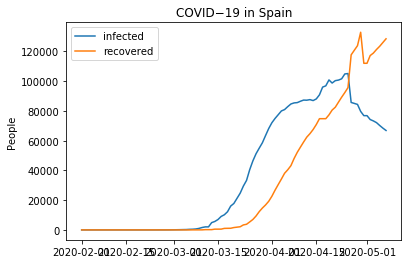

In [3]:
#Downloaded data:
plt.figure(1)
plt.plot(date,infected,label='infected')
plt.plot(date,recovered,label='recovered')
plt.title('COVID−19 in Spain')
plt.ylabel('People')
plt.legend(loc = 'best')
plt.show()

## SEIR epidemic model

### 1. Scenario 1. Interaction among people is always the same

### 1.1. SEIR model fitting.

Because of the sensitivity of the SEIR model to its initial conditions, we refused to compute the r-order sweep and directly fit the experimental data with the SEIR model. In this way we defined the orders of magnitud for both, the initial suceptible population and removal rate based on the previous SIR model studies.

In [4]:
# Defining the ODEs of the SEIR system:
def SEIR(y0,t,r,a,n):
    S,E,I,R = y0
    dSdt=-r*S*I
    dEdt=r*S*I-n*E
    dIdt=n*E-a*I
    dRdt=a*I
    return dSdt,dEdt,dIdt,dRdt

def model_SEIR(t,r,S0):
    return odeint(SEIR,[S0,1,1,0],t,args =(r,1/2.3,1/5.2))[:,2] 

In [5]:
params_SEIR,params_covariance_SEIR = curve_fit(model_SEIR,dt,infected,[1e-7,1e6]) 
r_value_SEIR = params_SEIR[0]
S0_value_SEIR = params_SEIR[1]
print('The fitted value for r is equal to:',r_value_SEIR)
print('The fitted value for the S0 population is:',S0_value_SEIR)

The fitted value for r is equal to: 8.181834966843685e-07
The fitted value for the S0 population is: 1480427.1584611596


### 1.2. Predicting when will be `R0`< 1 and the end of the epidemics.

Using the fitted SEIR model, when will the reproductive number `R0` become negative and when will the epidemic end?

In [6]:
fit_SEIR = model_SEIR(dt,r_value_SEIR,S0_value_SEIR)
maximumE = max(fit_SEIR)
tmaxE = np.where(fit_SEIR==maximumE)[0][0]

print('R_0 will become negative after: '+str(tmaxE)+' days of epidemic.')

'We further extend the time vector to depict the total evolution of the epidemic:'

dt_extended = np.linspace(1,300,300)
fit_SEIR_extended = model_SEIR(dt_extended,r_value_SEIR,S0_value_SEIR)


'We assume that the epidemic will finish when the rate of infected people per day is less than 1. '
fin_SEIR = 0
for index_ind in range(len(fit_SEIR_extended)):
    index_max=np.where(fit_SEIR_extended==max(fit_SEIR_extended))[0]

    if index_ind>index_max:
        if fit_SEIR_extended[index_ind] < 1:
            fin_SEIR = index_ind + 2 #0-indexing
            break 

print('No more people will get infected after '+str(fin_SEIR)+' days of epidemic.')

R_0 will become negative after: 76 days of epidemic.
No more people will get infected after 175 days of epidemic.


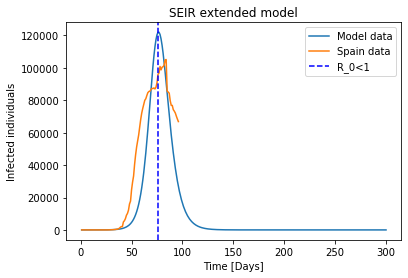

In [7]:
plt.figure(1)
plt.plot(dt_extended,fit_SEIR_extended,label='Model data')
plt.plot(dt,infected,label='Spain data')

plt.xlabel('Time [Days]')
plt.ylabel('Infected individuals')
plt.axvline(76,color='blue',linestyle= 'dashed',label='R_0<1')
plt.title('SEIR extended model')
plt.legend(loc='best')
plt.show()

## 2. Scenario 2: Confinement (quarantine) starts at some time

### 2.1. The `q`-value sweep.

Now we consider that the interaction among people is not always the same. Once a susceptible person gets infected, there is a time delay in which the infected person can infect other people until the symptoms come up and the infected person is quarantined. To model this new situation, first we are going to consider that at day 43rd infected people will be quarantined. So we will perform a SEIR model until day 43, which the SEIR model will be substituted by a SEIQR model.

In [8]:
#We consider the starting date of the confinment the day 43
day_conf=43
dt_pre_conf=np.linspace(1,day_conf,day_conf)
infected_pre_conf=list(infected[0:day_conf])

results_pre = odeint(SEIR,[S0_value_SEIR,1,1,0],dt_pre_conf,args =(r_value_SEIR,1/2.3,1/5.2))
S, E, I, R = results_pre.T

#Initial conditions for the SEIQR model, starting at day 43:
S_new=S[-1]
E_new=E[-1]
I_new=I[-1]
R_new=R[-1]

print('The intial conditions for the confinment are S0 = ',int(S[-1]),', E0 = ',int(E[-1]),', I0 = ',int(I[-1]),
      ', R0 = ',int(R[-1]))

The intial conditions for the confinment are S0 =  1471912 , E0 =  4157 , I0 =  1294 , R0 =  3065


In [9]:
# Defining the ODEs of the SEIQR system:

def SEIQR(y0,t,r,a,n,q):
    S,E,I,R = y0
    dSdt=-r*S*I
    dEdt=r*S*I-n*E
    dIdt=n*E-a*I-q*I
    dRdt=a*I+q*I
    return dSdt,dEdt,dIdt,dRdt

def model_SEIQR(t,q):
    return odeint(SEIQR,[S_new,E_new,I_new,R_new],t,args =(r_value_SEIR,1/2.3,1/5.2,q))[:,2]

To obtain the proper order for `q` we are going to use a sweep for different values of  `q` and compute the best fitting score.

In [10]:
'We need to split the time-vector and infected data into two different vectors'

dt_conf = np.linspace(1,len(infected)-day_conf,len(infected)-day_conf)
infected_conf = infected[day_conf:]
q_sweep = np.linspace(0.001,10,50)

'The r value is obtained from the initial SEIR model (the same value for scenario 1) and the initial conditions'
'were obtained modelling the first part of the system using the SeIR model:'

mse_c = []
for q in q_sweep:
    model_SEIR_conf = odeint(SEIQR,[S_new,E_new,I_new,R_new],dt[day_conf:],args =(r_value_SEIR,1/2.3,1/5.2,q))
    S, E, I, R = model_SEIR_conf.T
    mse_r = np.sum((I-infected_conf)**2)/len(infected_conf)
    mse_c.append(mse_r)
        
best_fit = min(mse_c)
index = mse_c.index(best_fit)
q_sweep_index = int(index/50)

print('Best fit: number of q'+' '+str(q_sweep[q_sweep_index]))

Best fit: number of q 0.001


### 2.2. SEIR-SEIQR model fitting.

Using the found q-order, we proceed to fit the SEIR-SEIQR model to experimental data:

In [11]:
params_SEIR_conf,params_covariance_SEIR_conf = curve_fit(model_SEIQR,dt[day_conf:],infected_conf,1e-2) 
q_value_SEIR_conf = params_SEIR_conf

print('The value for q is equal to:',q_value_SEIR_conf[0])

The value for q is equal to: 0.006002674795967492


R_0 will become negative after: 78 days of epidemic.
No more people will get infected after 177 days of epidemic.


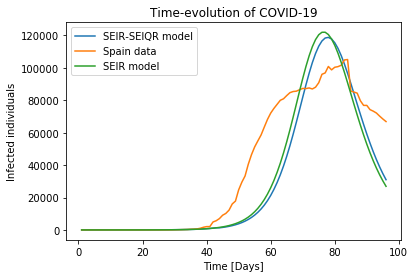

In [23]:
'Using the q-value of the fitting and the r-value of the scenario 1, we finally compute the SEIR-SEIQR model ' 
'The results are plotted comparing the SEIR-SEIQR results with experiemntal data.'

q_value=q_value_SEIR_conf
sweep_SEIR_conf=odeint(SEIQR,[S_new,E_new,I_new,R_new],dt[day_conf:],args =(r_value_SEIR,1/2.3,1/5.2,q_value))
S_sweep_conf, E_sweep_conf, I_sweep_conf, R_sweep_conf = sweep_SEIR_conf.T

I_conf=list(fit_SEIR_extended[0:day_conf])
I_conf.extend(I_sweep_conf)


'For this case, the reproductive ratio will become negative at:'

peak_q = max(I_conf)
tmax_q = I_conf.index(peak_q) + 1
print('R_0 will become negative after: '+str(tmax_q)+' days of epidemic.')


'Moreover, the epidemic will end at:'

dt_SEIQR_extend = np.linspace(1,300,300)
sw =odeint(SEIQR,[S_new,E_new,I_new,R_new],dt_SEIQR_extend[day_conf:],args =(r_value_SEIR,1/2.3,1/5.2,q_value))[:,2]
I_q_extend = list(fit_SEIR_extended[0:day_conf])
I_q_extend.extend(sw)


fin_SEIQR = 0
cont_q = 0

for individual in I_q_extend:
    if individual < 1 and cont_q > 40:
        fin_SEIQR = cont_q + 2 #0-indexing
        break 
    else: 
        cont_q = cont_q+1
        
print('No more people will get infected after '+str(fin_SEIQR)+' days of epidemic.')

plt.figure(1)
plt.plot(dt,I_conf,label='SEIR-SEIQR model')
plt.plot(dt,infected,label='Spain data')
plt.plot(dt,fit_SEIR,label='SEIR model')
plt.xlabel('Time [Days]')
plt.ylabel('Infected individuals')
plt.title('Time-evolution of COVID-19')
plt.legend(loc='best')
plt.show()

As it can be seen by the last figure, the SEIR-SEIQR system models better the experimental data than SEIR did in scenario 1. Indeed, the SEIQR model reduces the spread of the disease among susceptible people.

### 2.3. Studying the effect of different types of quarantine.

At this point of the study, we are going to analyze the effect of different types of quarantine (less or more restrictive) and how it does affect the total number of infected people. We will use the same SEIR-SEIQR model and the starting confinement date as 43.

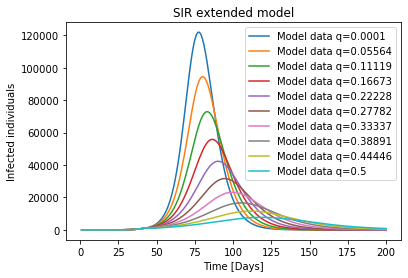

,I_max,When R0 becomes <1,q
0,121936.0,[77],0.000100
1,94586.0,[79],0.055644
2,72954.0,[82],0.111189
3,55839.0,[85],0.166733
4,42349.0,[89],0.222278
5,31664.0,[94],0.277822
6,23254.0,[99],0.333367
7,16680.0,[104],0.388911
8,11598.0,[111],0.444456
9,7746.0,[118],0.500000


In [24]:
#we set the date of confinment to 43
d=43
#we sweep the value of q
q_sweep=np.linspace(1e-4,5e-1,10)
#time before
dt_pre_conf=np.linspace(1,d,d)
#total time
dt_extended=np.linspace(1,200,200)


#before
results_pre = odeint(SEIR,[S0_value_SEIR,1,1,0],dt_pre_conf,args =(r_value_SEIR,1/2.3,1/5.2))
S, E, I, R = results_pre.T
S_new=S[-1]
E_new=E[-1]
I_new=I[-1]
R_new=R[-1]

#after
I_max=[]
day_max=[]
for q in q_sweep:
    SEIR_results_conf=odeint(SEIQR,[S_new,E_new,I_new,R_new],dt_extended[d:],args =(r_value_SEIR,1/2.3,1/5.2,q))
    S_conf, E_conf, I_conf, R_conf = SEIR_results_conf.T
    #I_conf_total=list(fit_SIR_extended[0:43])
    I_conf_total=list(I)
    I_conf_total.extend(I_conf)
    I_max.append(round(max(I_conf_total)))
    day_max.append(np.where(I_conf_total==max(I_conf_total))[0])  
    
    #plot
    plt.plot(dt_extended,I_conf_total,label='Model data q={}'.format(round(q,5)))

plt.xlabel('Time [Days]')
plt.ylabel('Infected individuals')
plt.title('SIR extended model')
plt.legend(loc='best')
plt.show()
data = {'q': list(q_sweep),'I_max': I_max, "When R0 becomes <1": day_max}
df = pd.DataFrame(data=data)
df    

The more restrictive is a quarantine, the less people will get infected. 

### 2.4. Studying the effect of the date of the confinment for a level of confinment q.

In this exercise q-value was fixed with one of the values from the last exercise for a better resolution of the results.

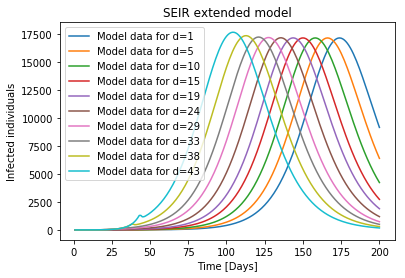

,Date,I_max,When R0 becomes <1
0,1,17119.0,[173]
1,5,17119.0,[165]
2,10,17120.0,[157]
3,15,17122.0,[149]
4,19,17122.0,[143]
5,24,17131.0,[135]
6,29,17153.0,[126]
7,33,17200.0,[120]
8,38,17321.0,[112]
9,43,17627.0,[103]


In [94]:
#we set the level of confinment to 
q=0.38
#we sweep the value of the day
d_list=np.linspace(1,43,10)
d_list=[int(d) for d in d_list]
#total time
dt_extended=np.linspace(1,200,200)

I_max=[]
day_max=[]

for d in d_list:
    #time before
    dt_pre_conf=np.linspace(1,d,d)
    #before
    results_pre = odeint(SEIR,[S0_value_SEIR,1,1,0],dt_pre_conf,args =(r_value_SEIR,1/2.3,1/5.2))
    S, E, I, R = results_pre.T
    S_new=S[-1]
    E_new=E[-1]
    I_new=I[-1]
    R_new=R[-1]

    #after
    SEIR_results_conf=odeint(SEIQR,[S_new,E_new,I_new,R_new],dt_extended[d:],args =(r_value_SEIR,1/2.3,1/5.2,q))
    S_conf, E_conf, I_conf, R_conf = SEIR_results_conf.T
    I_conf_total=list(I)
    I_conf_total.extend(I_conf)
    I_max.append(round(max(I_conf_total)))
    day_max.append(np.where(I_conf_total==max(I_conf_total))[0])  
    
    #plot
    plt.plot(dt_extended,I_conf_total,label='Model data for d={}'.format(d))

plt.xlabel('Time [Days]')
plt.ylabel('Infected individuals')
plt.title('SEIR extended model')
plt.legend(loc='best')
plt.show()
data = {'Date': list(d_list),'I_max': I_max, "When R0 becomes <1": day_max}
df = pd.DataFrame(data=data)
df    

From the table we can conclude that as soon as an epidemic is detected, the quarantine of infected people should be established immediately.